In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import sys
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Compatibilidade com diferentes versões do TensorFlow
AUTOTUNE = getattr(tf.data, "AUTOTUNE", tf.data.experimental.AUTOTUNE)

# Carrega CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Função de preprocessamento usando ResNet50
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)  # Pré-processamento oficial do ResNet50
    return image, label

# Dataset eficiente
batch_size = 64
train_ds = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
            .map(preprocess, num_parallel_calls=AUTOTUNE)
            .shuffle(1000)
            .batch(batch_size)
            .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
           .map(preprocess, num_parallel_calls=AUTOTUNE)
           .batch(batch_size)
           .prefetch(AUTOTUNE))

In [2]:
# Modelo ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5
782/782 [==============================] - 105s 135ms/step - loss: 0.5362 - accuracy: 0.8195 - val_loss: 0.3192 - val_accuracy: 0.8947
Epoch 2/5
782/782 [==============================] - 105s 134ms/step - loss: 0.3835 - accuracy: 0.8710 - val_loss: 0.3032 - val_accuracy: 0.8955
Epoch 3/5
782/782 [==============================] - 105s 134ms/step - loss: 0.3432 - accuracy: 0.8840 - val_loss: 0.2879 - val_accuracy: 0.9042
Epoch 4/5
782/782 [==============================] - 105s 134ms/step - loss: 0.3201 - accuracy: 0.8919 - val_loss: 0.2848 - val_accuracy: 0.9052
Epoch 5/5
782/782 [==============================] - 105s 134ms/step - loss: 0.3009 - accuracy: 0.8958 - val_loss: 0.2909 - val_accuracy: 0.9062


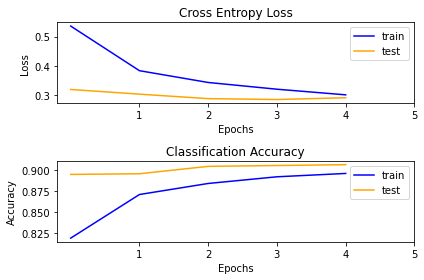

In [3]:
# plot diagnostic learning curves

# plot loss
plt.subplot(2,1,1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# define ticks do eixo X de 1 em 1
x_ticks = np.arange(1, len(history.history['loss']) + 1, step=1)
plt.xticks(x_ticks)  # <-- adiciona ticks de 1 em 1

# plot accuracy
plt.subplot(2,1,2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(x_ticks)

# save plot to file
plt.tight_layout()
figs_path = "/home/user1-lipai/Maycon/TCC_Maycon_XAI/ResNet50/cifar-10/figures/"
plt.savefig(figs_path + 'CIFAR-10_ResNet50' + '_train_plot.png', dpi=300, bbox_inches='tight')

# plot fig
plt.show()
plt.close()

In [4]:
model.save('/home/user1-lipai/Maycon/TCC_Maycon_XAI/ResNet50/cifar-10/models/resnet50_cifar-10')
print("FIM")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/user1-lipai/Maycon/TCC/ResNet50/models/resnet50_cifar-10/assets
FIM


In [3]:
model = tf.keras.models.load_model('/home/user1-lipai/Maycon/TCC_Maycon_XAI/ResNet50/cifar-10/models/resnet50_cifar-10')
print("FIM")

FIM


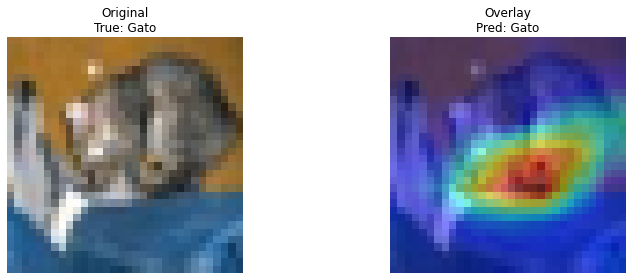

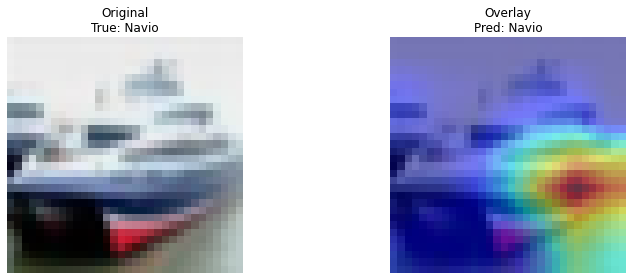

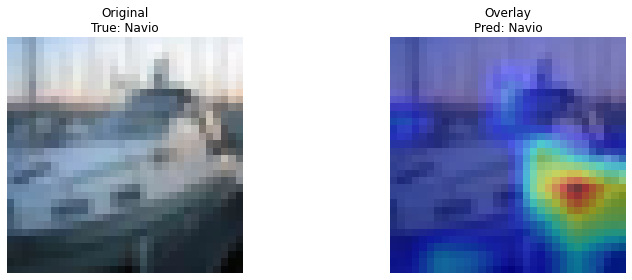

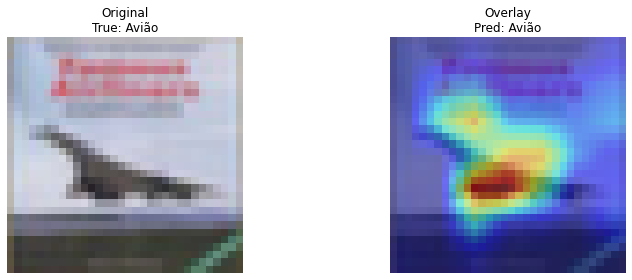

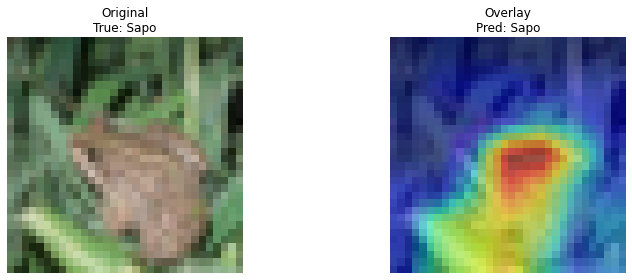

In [7]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

# Função Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.layers[0]
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    conv_model = tf.keras.Model(base_model.input, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = tf.keras.layers.GlobalAveragePooling2D()(classifier_input)
    for layer in model.layers[2:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array)
        tape.watch(conv_outputs)
        preds = classifier_model(conv_outputs)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
#         print(f"Gradientes None para classe {pred_index}")
        return np.zeros(conv_outputs.shape[1:3])

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) == 0:
        return np.zeros_like(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

    # Gradientes
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Grad-CAM
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Número de imagens do teste para mostrar
num_images = 5
last_conv_layer_name = "conv5_block3_out"

classes = ["Avião", "Automóvel", "Pássaro", "Gato", "Cervo", "Cachorro", "Sapo", "Cavalo", "Navio", "Caminhão"]

for idx in range(num_images):
    image = x_test[idx]
    label_true = np.argmax(y_test[idx])
    
    # Preprocessamento
    image_resized = tf.image.resize(image, (224, 224))
    image_input = tf.expand_dims(preprocess_input(image_resized), axis=0)
    
    # Previsão
    preds = model.predict(image_input)
    label_pred = np.argmax(preds[0])
    
    # Grad-CAM
    heatmap = make_gradcam_heatmap(image_input, model, last_conv_layer_name, pred_index=label_pred)
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (32,32))
    
    # Visualização lado a lado
    plt.figure(figsize=(12,4))
    
    # Imagem original
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.title(f"Original\nTrue: {classes[label_true]}")
    plt.axis('off')
    
    # Imagem com heatmap sobreposto
    plt.subplot(1,2,2)
    plt.imshow(image)
    plt.imshow(heatmap_resized[:,:,0], cmap='jet', alpha=0.5)
    plt.title(f"Overlay\nPred: {classes[label_pred]}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


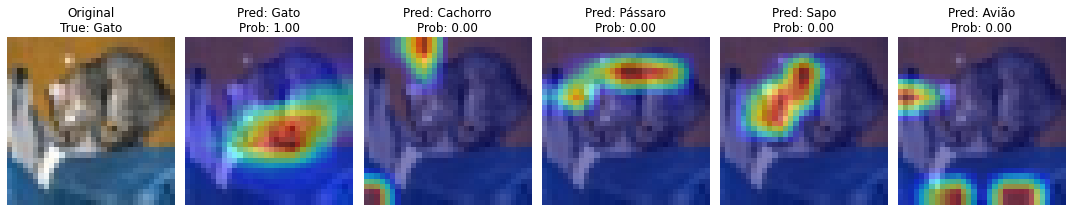

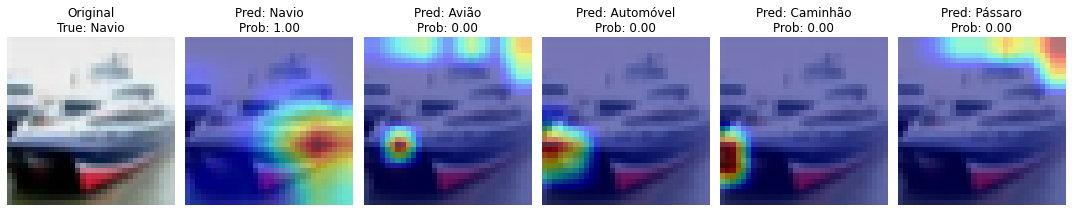

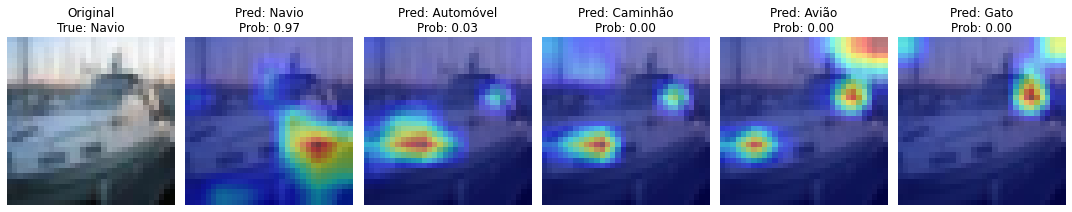

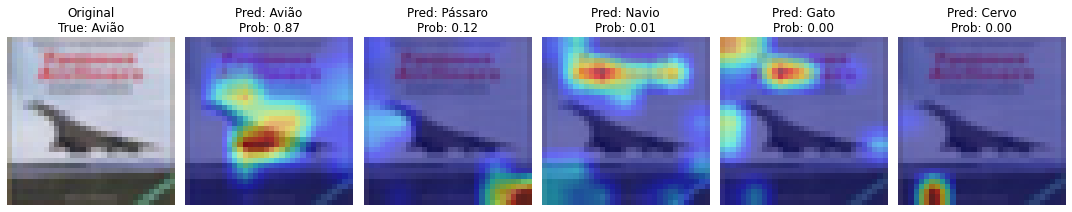

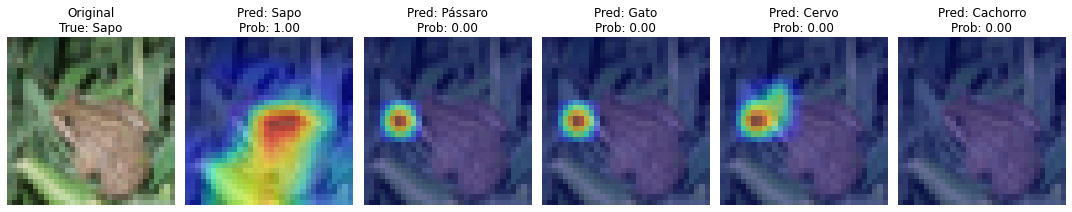

In [8]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    base_model = model.layers[0]
    last_conv_layer = base_model.get_layer(last_conv_layer_name)

    conv_model = tf.keras.Model(base_model.input, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = tf.keras.layers.GlobalAveragePooling2D()(classifier_input)
    for layer in model.layers[2:]:
        x = layer(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        conv_outputs = conv_model(img_array)
        tape.watch(conv_outputs)
        preds = classifier_model(conv_outputs)

        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
#         print(f"Gradientes None para classe {pred_index}")
        return np.zeros(conv_outputs.shape[1:3])

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    if tf.reduce_max(heatmap) == 0:
        return np.zeros_like(heatmap)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

    # Gradientes
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    # Grad-CAM
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)
    return heatmap.numpy()

classes = ["Avião", "Automóvel", "Pássaro", "Gato", "Cervo", "Cachorro", "Sapo", "Cavalo", "Navio", "Caminhão"]
num_images = 5
last_conv_layer_name = "conv5_block3_out"
n_top_classes = 5

for idx in range(num_images):

    # Escolher uma imagem do teste
    image = x_test[idx]
    label_true = np.argmax(y_test[idx])

    # Preprocessamento
    image_resized = tf.image.resize(image, (224, 224))
    image_input = tf.expand_dims(preprocess_input(image_resized), axis=0)

    # Previsão do modelo
    preds = model.predict(image_input)
    top_classes = np.argsort(preds[0])[(-1*n_top_classes):][::-1]  # Top n classes previstas

    heatmaps = []

    # Gerar Grad-CAM para cada uma das top 5 classes
    for cls in top_classes:
        heatmap = make_gradcam_heatmap(image_input, model, last_conv_layer_name, pred_index=cls)
        heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (32,32))
        heatmaps.append((cls, heatmap_resized))

    # Visualização lado a lado
    plt.figure(figsize=(15,5))
    plt.subplot(1, len(heatmaps)+1, 1)
    plt.imshow(image)
    plt.title(f"Original\nTrue: {classes[label_true]}")
    plt.axis('off')

    for i, (cls, heatmap) in enumerate(heatmaps):
        plt.subplot(1, len(heatmaps)+1, i+2)
        plt.imshow(image)
        plt.imshow(heatmap[:,:,0], cmap='jet', alpha=0.5)
        plt.title(f"Pred: {classes[cls]}\nProb: {preds[0][cls]:.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
